# Credit Risk Scoring

In [1]:
import pandas as pd
import numpy as np
import wget

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Data cleaning and preparation

In [2]:
link = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
wget.download(link)

100% [.........................................................................] 182489 / 182489

'CreditScoring (4).csv'

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [5]:
df.dtypes

status       int64
seniority    int64
home         int64
time         int64
age          int64
marital      int64
records      int64
job          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
dtype: object

In [6]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [7]:
df.status.value_counts(normalize=True)

1    0.718294
2    0.281481
0    0.000224
Name: status, dtype: float64

In [8]:
# reformat the categorical variables which are int64 into object
# so we could use one-hot encoding later on

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unknown'
}

# we can do this using map() function
df.status = df.status.map(status_values)
df.status.value_counts()

ok         3200
default    1254
unknown       1
Name: status, dtype: int64

In [9]:
# do the same with other features

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unknown'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unknown'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unknown'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unknown'
}

df.job = df.job.map(job_values)

In [10]:
# checking

df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [11]:
# in income, assets and debt we have 99999999 values which stand for NaN
# so we need to replce them

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [12]:
# to_replace=99999999 indicates what we want to replace
# value=np.nan indicates what we want to replace with

for i in ['income', 'assets', 'debt']:
    df[i] = df[i].replace(to_replace=99999999, value=np.nan)

In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [14]:
# let's drop the unknown status

df = df[df.status != 'unknown'].reset_index(drop=True)
df.status.value_counts()

ok         3200
default    1254
Name: status, dtype: int64

# Split the dataset

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# splitting into train and test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# splitting train into train & validation
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [17]:
# checking datasets lenght

len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [18]:
# resetting the index

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
# creating our 'y' values (status) and transforming Series to NumPy array using .values
# we comparing it default status to get 1, so we could predict default

y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

# deleting 'y' (churn) from 'X' dataset

del df_train['status']
del df_val['status']
del df_test['status']

In [20]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,14,owner,60,30,married,no,fixed,60,70.0,4000.0,2800.0,600,1125
1,2,parents,60,35,married,no,fixed,75,104.0,0.0,0.0,1200,1677
2,8,rent,36,61,single,no,fixed,42,72.0,0.0,0.0,325,450
3,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
4,2,other,60,41,separated,no,freelance,35,100.0,5000.0,0.0,1200,1450


In [21]:
y_train

array([0, 0, 0, ..., 0, 0, 1])

# Decision trees

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [23]:
# perform one-hot encoding for training dataset

train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [24]:
# train the training dataset

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
# perform one-hot encoding for validation dataset

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [26]:
# making a prediction and checking AUC on validation datset

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6564491045000753

In [27]:
# making a prediction and checking AUC on training datset

y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

# we've got ~ 1, which indicates overfitting

0.9999996473061242

In [28]:
# we may generalize model by limiting max depth of the tree

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [29]:
# re-training the model and checking AUC

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7175133670978937
val: 0.7128913108914865


In [30]:
# visualization of the tree

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- seniority <= 2.50
|   |--- records=no <= 0.50
|   |   |--- class: 1
|   |--- records=no >  0.50
|   |   |--- class: 0
|--- seniority >  2.50
|   |--- records=yes <= 0.50
|   |   |--- class: 0
|   |--- records=yes >  0.50
|   |   |--- class: 0



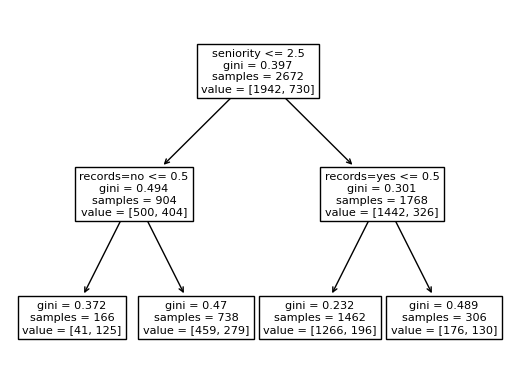

In [31]:
# another way of visualing of the tree

from sklearn.tree import plot_tree

plt.figure()
plot_tree(dt, max_depth=2, feature_names=dv.get_feature_names_out().tolist());

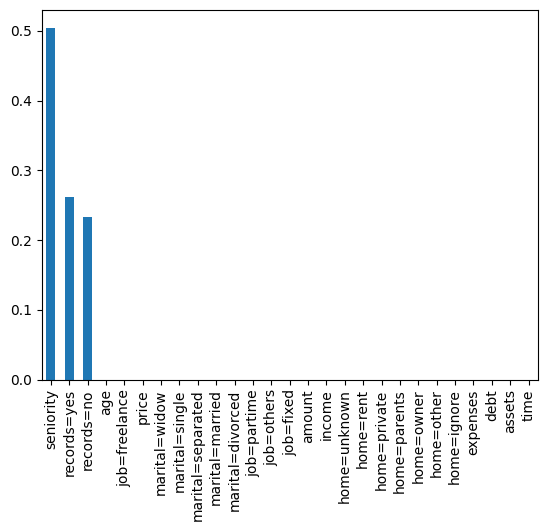

In [32]:
# example of calculating feature importance

importances = dt.feature_importances_

forest_importances = pd.Series(importances, index=dv.get_feature_names_out().tolist()).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

# Decision trees parameter tuning

In [33]:
# let's check what max_depth is the best

depths = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.643
   2 -> 0.713
   3 -> 0.746
   4 -> 0.755
   5 -> 0.764
   6 -> 0.763
   7 -> 0.734
  10 -> 0.664
  15 -> 0.637
  20 -> 0.651
None -> 0.651


In [34]:
# let's find the best combination of the depth and 

scores = []

for depth in [4, 5, 6, 7, 8]:
    for s in [1, 3, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=42)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [35]:
# creating table for the scores

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                            
max_depth             4      5      6      7      8
min_samples_leaf                                   
1                 0.755  0.764  0.763  0.734  0.713
3                 0.755  0.767  0.777  0.759  0.751
5                 0.755  0.768  0.775  0.762  0.756
10                0.753  0.768  0.779  0.770  0.756
15                0.762  0.775  0.785  0.771  0.768
20                0.762  0.766  0.779  0.770  0.770
100               0.762  0.769  0.770  0.770  0.770
200               0.754  0.759  0.760  0.760  0.760
500               0.697  0.697  0.697  0.697  0.697

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

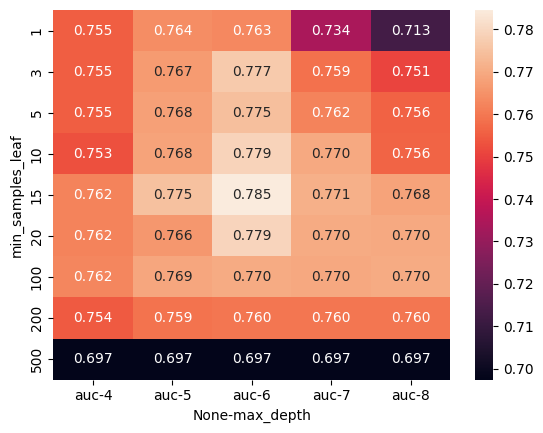

In [36]:
# creating heatmap of the scores

sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [37]:
# training data with the best params

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15, random_state=42)

In [38]:
# re-training the model and checking AUC

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.85987366505368
val: 0.7845407113831334


In [39]:
import sklearn.metrics as metrics

print("Decision Tree")
print("ROC AUC:", "%.6f" % metrics.roc_auc_score(y_val, y_pred))
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_val, y_pred>0.5))
print("Precision:", "%.6f" % metrics.precision_score(y_val, y_pred>0.5))
print("Recall:", "%.6f" % metrics.recall_score(y_val, y_pred>0.5))
print("F1 Score:", "%.6f" % metrics.f1_score(y_val, y_pred>0.5))

Decision Tree
ROC AUC: 0.784541
Accuracy: 0.755331
Precision: 0.578947
Recall: 0.443548
F1 Score: 0.502283


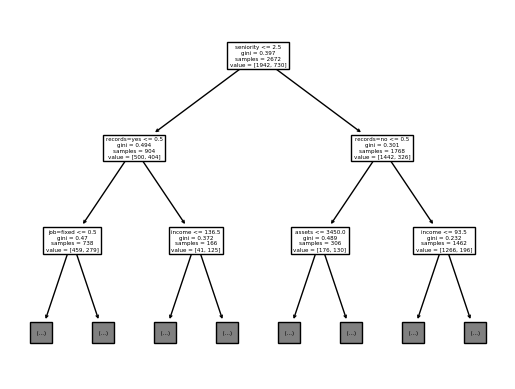

In [40]:
# visualing the tree from training dataset

from sklearn.tree import plot_tree

plt.figure()
plot_tree(dt, max_depth=2, feature_names=dv.get_feature_names_out().tolist());

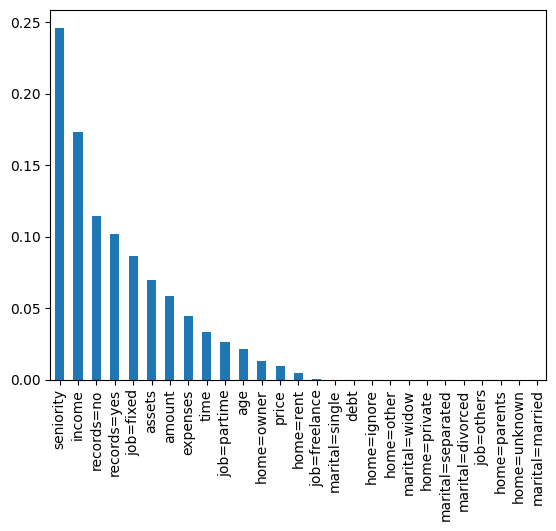

In [41]:
# calculating feature importance from training dataset

importances = dt.feature_importances_

forest_importances = pd.Series(importances, index=dv.get_feature_names_out().tolist()).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

# Decision trees parameter tuning via GridSearch

In [42]:
from sklearn.model_selection import GridSearchCV

tree_para = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50],
             'min_samples_leaf': [2,3,4,5,6,7,8,9, 10, 15, 20, 50]}

scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

In [43]:
import warnings
warnings.filterwarnings('ignore')

tuned_decision_tree = DecisionTreeClassifier(random_state=42)

clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 30, 40,
                                       50],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
                                              20, 50]},
             refit='f1',
             scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'])

In [44]:
# Computing the best combination of values for the hyperparameters

clf.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, random_state=42)

In [45]:
# best f1 score

print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.5466


In [46]:
# Printing out the decision tree model's accuracy, precision, recall, and F1 score

results = pd.DataFrame(columns=['Model', 'ROC AUC', 'F1', 'Recall', 'Precision', 'Accuracy'])

def make_results(model_name, model_object):
    """
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    """

    # Get all the results from the CV and put them in a df.
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score).
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row.
    roc_auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create a table of results.
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                          'ROC AUC': roc_auc,
                          'F1': f1,
                          'Recall': recall,
                          'Precision': precision,
                          'Accuracy': accuracy},
                         ignore_index=True)

    return table

result_table = make_results("Tuned Decision Tree", clf)

result_table

,Model,ROC AUC,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.771774,0.546583,0.50274,0.609306,0.773572


# Ensembles and Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
# baseline model

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
    
auc

0.8211978879245473

# Parameter tuning for Random Forest

In [49]:
# looping over number of estimators (models) to see the best auc

scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%s -> %.3f' % (n, auc))
    
    scores.append((n, auc))

10 -> 0.785
20 -> 0.799
30 -> 0.803
40 -> 0.810
50 -> 0.813
60 -> 0.817
70 -> 0.820
80 -> 0.820
90 -> 0.821
100 -> 0.821
110 -> 0.821
120 -> 0.823
130 -> 0.823
140 -> 0.824
150 -> 0.825
160 -> 0.823
170 -> 0.823
180 -> 0.823
190 -> 0.823
200 -> 0.823


In [50]:
scores

[(10, 0.7847946872021272),
 (20, 0.7993622384989715),
 (30, 0.8033411929965384),
 (40, 0.809624742888677),
 (50, 0.812612878141775),
 (60, 0.8170151256709979),
 (70, 0.819959363868961),
 (80, 0.8202760497667185),
 (90, 0.8214581347514172),
 (100, 0.8211978879245473),
 (110, 0.8212323784678673),
 (120, 0.8225555611297848),
 (130, 0.8226621682636834),
 (140, 0.823565193397883),
 (150, 0.8246124517132394),
 (160, 0.8229286860984296),
 (170, 0.822884789043295),
 (180, 0.8234805347915517),
 (190, 0.8234899413033662),
 (200, 0.8231168163347212)]

In [51]:
# ploting scores

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

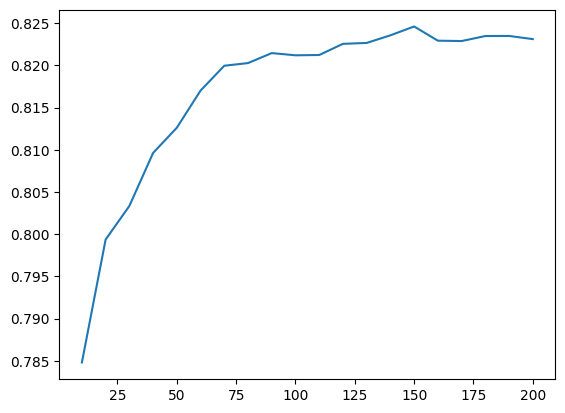

In [52]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [53]:
# looping over max_depth and number of estimators

scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [54]:
scores

[(5, 10, 0.8151212812923293),
 (5, 20, 0.810599884613455),
 (5, 30, 0.8136319169216877),
 (5, 40, 0.8170621582300707),
 (5, 50, 0.8178554407264336),
 (5, 60, 0.8178523052224953),
 (5, 70, 0.8216901620428436),
 (5, 80, 0.8207369688456329),
 (5, 90, 0.8205551096172177),
 (5, 100, 0.8207996789243968),
 (5, 110, 0.8209125570661717),
 (5, 120, 0.820868660011037),
 (5, 130, 0.820172578136758),
 (5, 140, 0.8210567902473285),
 (5, 150, 0.8212825465308784),
 (5, 160, 0.8216713490192145),
 (5, 170, 0.8216588070034615),
 (5, 180, 0.8219723573972808),
 (5, 190, 0.8214393217277881),
 (5, 200, 0.8216274519640798),
 (10, 10, 0.8025918075553102),
 (10, 20, 0.815914563788692),
 (10, 30, 0.8148547634575828),
 (10, 40, 0.8189685446244921),
 (10, 50, 0.8214957607986756),
 (10, 60, 0.8221291325941905),
 (10, 70, 0.823502483319119),
 (10, 80, 0.8255781869262028),
 (10, 90, 0.8256158129734611),
 (10, 100, 0.8260986805799427),
 (10, 110, 0.8258352982491347),
 (10, 120, 0.8268261174936036),
 (10, 130, 0.825979

In [55]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [56]:
# creating table for the scores

df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth        5      10     15
n_estimators                     
10            0.815  0.803  0.777
20            0.811  0.816  0.800
30            0.814  0.815  0.811
40            0.817  0.819  0.812
50            0.818  0.821  0.813
60            0.818  0.822  0.816
70            0.822  0.824  0.821
80            0.821  0.826  0.821
90            0.821  0.826  0.821
100           0.821  0.826  0.822
110           0.821  0.826  0.822
120           0.821  0.827  0.824
130           0.820  0.826  0.822
140           0.821  0.826  0.824
150           0.821  0.826  0.824
160           0.822  0.827  0.822
170           0.822  0.827  0.821
180           0.822  0.827  0.822
190           0.821  0.828  0.822
200           0.822  0.828  0.822

<Axes: xlabel='None-max_depth', ylabel='n_estimators'>

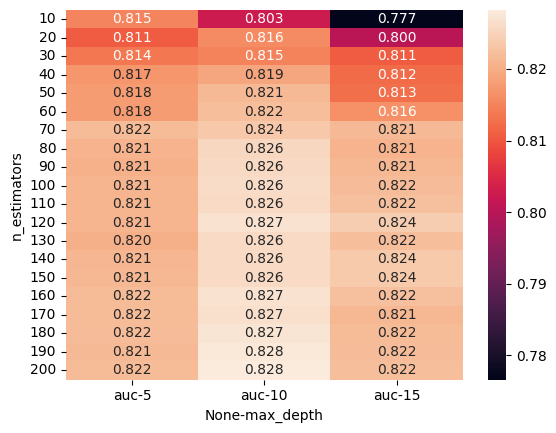

In [57]:
# creating heatmap of the scores

sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

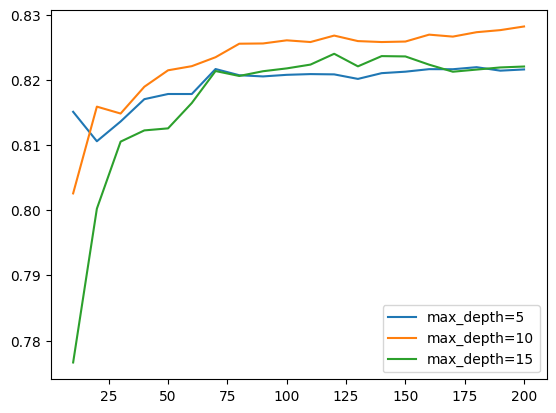

In [58]:
# visualizing scores

for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [59]:
# fixing the max_depth and looping over min_samples_leaf and number of estimators

max_depth = 10
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [60]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

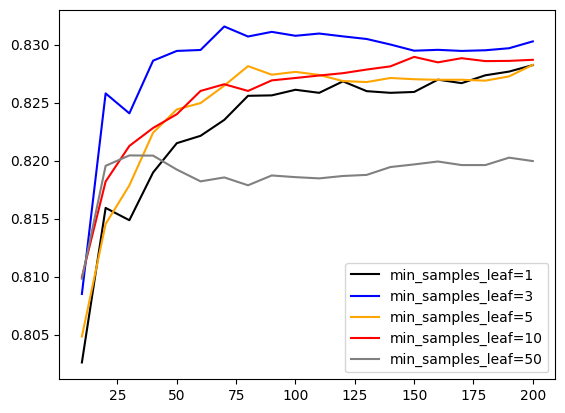

In [61]:
# visualizing scores

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [62]:
df_scores.shape

(100, 3)

In [63]:
# finding the best auc

df_scores.sort_values(by='auc', ascending=False).head(5)

,min_samples_leaf,n_estimators,auc
26,3,70,0.831554
28,3,90,0.831090
30,3,110,0.830946
29,3,100,0.830752
31,3,120,0.830702


In [64]:
# training the best model

rf = RandomForestClassifier(n_estimators=70,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=70,
                       random_state=42)

In [65]:
# checking

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

auc

0.8315544574323984

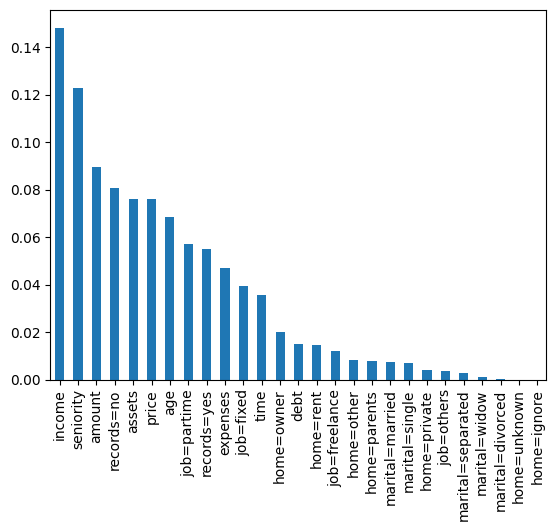

In [66]:
# calculating feature importance from training dataset

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=dv.get_feature_names_out().tolist()).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

Other useful parametes:

* `max_features`
* `bootstrap`

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Gradient boosting and XGBoost

In [67]:
import xgboost as xgb

In [68]:
# XGBoot has a special matrix DMatrix, which is optimized for faster gradient boosting calculations

features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [69]:
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6,
    'min_child_weight': 1, # min_samples_leaf
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10) # num_boost_round is number of trees

In [70]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8254276827371696

In [71]:
# we can see what results eavh round of boosting have

watchlist = [(dtrain, 'train'), (dval, 'val')]

# %%capture output captures the output and stores it in output

In [72]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 42,
    
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, # sets how often to print eval_metrics
                  evals=watchlist)

In [73]:
print(output)

[0]	train-auc:0.85639	val-auc:0.78434
[5]	train-auc:0.92432	val-auc:0.81784
[10]	train-auc:0.94874	val-auc:0.82721
[15]	train-auc:0.96153	val-auc:0.82844
[20]	train-auc:0.97736	val-auc:0.82267
[25]	train-auc:0.98602	val-auc:0.81769
[30]	train-auc:0.99019	val-auc:0.81648
[35]	train-auc:0.99331	val-auc:0.81385
[40]	train-auc:0.99667	val-auc:0.80855
[45]	train-auc:0.99742	val-auc:0.80577
[50]	train-auc:0.99831	val-auc:0.80359
[55]	train-auc:0.99865	val-auc:0.80359
[60]	train-auc:0.99928	val-auc:0.80261
[65]	train-auc:0.99958	val-auc:0.80359
[70]	train-auc:0.99966	val-auc:0.80447
[75]	train-auc:0.99973	val-auc:0.80457
[80]	train-auc:0.99989	val-auc:0.80269
[85]	train-auc:0.99994	val-auc:0.80244
[90]	train-auc:0.99996	val-auc:0.80155
[95]	train-auc:0.99999	val-auc:0.79837
[100]	train-auc:1.00000	val-auc:0.79664
[105]	train-auc:1.00000	val-auc:0.79582
[110]	train-auc:1.00000	val-auc:0.79395
[115]	train-auc:1.00000	val-auc:0.79419
[120]	train-auc:1.00000	val-auc:0.79384
[125]	train-auc:1.0000

In [74]:
# function for parsing captured output

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [75]:
# parsing and storing the result

df_score = parse_xgb_output(output)

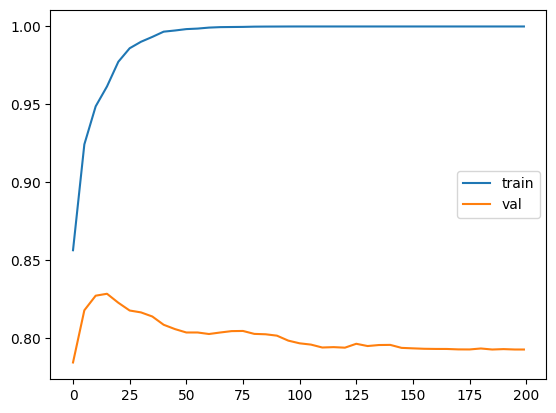

In [76]:
# visualizing scores for train and validation

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

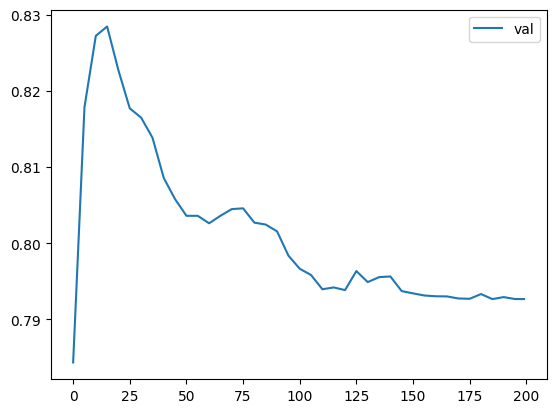

In [77]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

# XGBoost parameter tuning: learning rate

In [78]:
# let's change the learning rate (eta) param from 0.3 to 0.1
# it's the size of the step

In [79]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [80]:
# setting a key for dict with eta=0.01

'eta=%s' % (xgb_params['eta'])

'eta=0.01'

In [81]:
# extracting scores for eta=0.01

key = 'eta=%s' % (xgb_params['eta'])

# setting up a dict for eta=x as a key for scores for this eta
scores = {}

scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [82]:
# contains scores for eta=0.01

scores

{'eta=0.01':     num_iter  train_auc  val_auc
 0          0    0.85639  0.78434
 1          5    0.86080  0.78671
 2         10    0.87142  0.78577
 3         15    0.87514  0.78521
 4         20    0.88648  0.79419
 5         25    0.89122  0.79844
 6         30    0.89412  0.80115
 7         35    0.89595  0.80008
 8         40    0.89864  0.80163
 9         45    0.90042  0.80245
 10        50    0.90201  0.80276
 11        55    0.90331  0.80333
 12        60    0.90444  0.80342
 13        65    0.90630  0.80484
 14        70    0.90796  0.80678
 15        75    0.90958  0.80830
 16        80    0.91076  0.80934
 17        85    0.91173  0.81077
 18        90    0.91260  0.81166
 19        95    0.91394  0.81320
 20       100    0.91514  0.81396
 21       105    0.91639  0.81461
 22       110    0.91755  0.81550
 23       115    0.91856  0.81608
 24       120    0.91982  0.81699
 25       125    0.92079  0.81716
 26       130    0.92179  0.81750
 27       135    0.92288  0.81784
 2

In [83]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [84]:
# setting a key for dict with eta=0.5

'eta=%s' % (xgb_params['eta'])

'eta=0.5'

In [85]:
# extracting scores for eta=0.5

key = 'eta=%s' % (xgb_params['eta'])

scores[key] = parse_xgb_output(output)
key

'eta=0.5'

In [86]:
scores['eta=0.5']

,num_iter,train_auc,val_auc
0,0,0.85639,0.78434
1,5,0.94259,0.81770
2,10,0.96121,0.81184
3,15,0.98002,0.80041
4,20,0.98885,0.79955
5,25,0.99547,0.79844
6,30,0.99818,0.79732
7,35,0.99905,0.79542
8,40,0.99946,0.79238
9,45,0.99968,0.79040


In [87]:
# checking what keys and scores we have so far
# we may itirate over eta numbers to get scores for different values

scores.keys()

dict_keys(['eta=0.01', 'eta=0.5'])

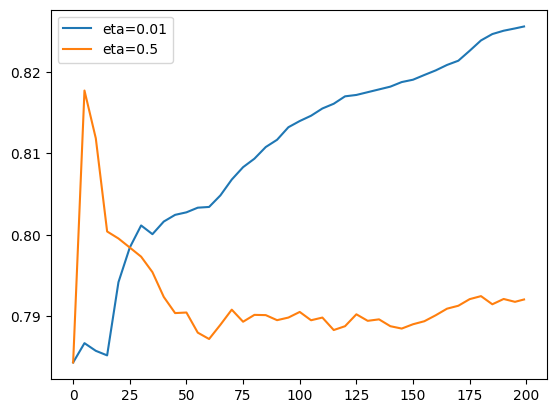

In [88]:
# we iterate over scores dict and plot scores for validation

for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

# XGBoost parameter tuning: max_depth

In [89]:
# let's tune max_depth with eta=0.01

In [90]:
scores = {}

In [91]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [92]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [93]:
scores.keys()

dict_keys(['max_depth=6'])

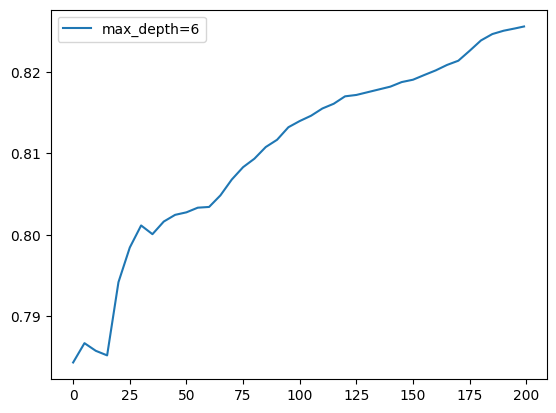

In [94]:
# visualizing

for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
    
plt.legend()

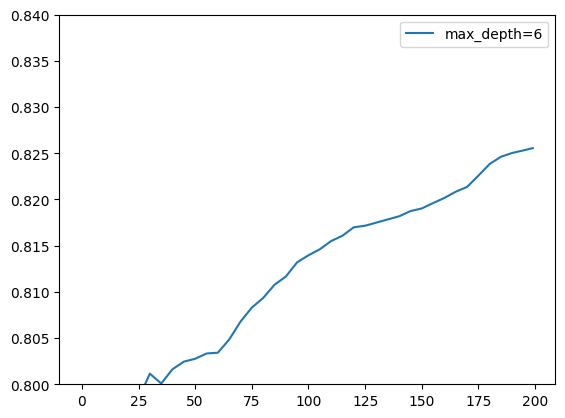

In [95]:
# visualizing

for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
    
plt.ylim(0.8, 0.84) # zooming in y
plt.legend()

# XGBoost parameter tuning: min_child_weight

In [96]:
scores = {}

In [97]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 4,
    'min_child_weight': 50,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [98]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=50'

In [99]:
scores.keys()

dict_keys(['min_child_weight=50'])

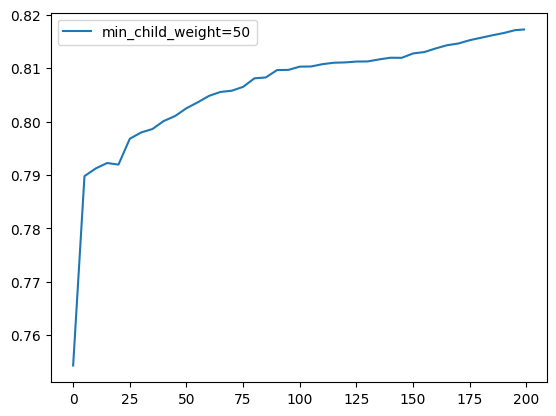

In [100]:
# visualizing

for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
    
plt.legend()

In [101]:
# final model

xgb_params = {
    'eta': 0.01, 
    'max_depth': 4,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-auc:0.79979	val-auc:0.75451
[5]	train-auc:0.80515	val-auc:0.75941
[10]	train-auc:0.82683	val-auc:0.78012
[15]	train-auc:0.83198	val-auc:0.78429
[20]	train-auc:0.83461	val-auc:0.78657
[25]	train-auc:0.83569	val-auc:0.78660
[30]	train-auc:0.83734	val-auc:0.78769
[35]	train-auc:0.83857	val-auc:0.79023
[40]	train-auc:0.83953	val-auc:0.79105
[45]	train-auc:0.84384	val-auc:0.79388
[50]	train-auc:0.84551	val-auc:0.79534
[55]	train-auc:0.84783	val-auc:0.79800
[60]	train-auc:0.84973	val-auc:0.79971
[65]	train-auc:0.85206	val-auc:0.80159
[70]	train-auc:0.85355	val-auc:0.80259
[75]	train-auc:0.85521	val-auc:0.80396
[80]	train-auc:0.85709	val-auc:0.80556
[85]	train-auc:0.85869	val-auc:0.80672
[90]	train-auc:0.86054	val-auc:0.80867
[95]	train-auc:0.86240	val-auc:0.81020
[100]	train-auc:0.86400	val-auc:0.81174
[105]	train-auc:0.86528	val-auc:0.81290
[110]	train-auc:0.86667	val-auc:0.81401
[115]	train-auc:0.86764	val-auc:0.81475
[120]	train-auc:0.86911	val-auc:0.81578
[125]	train-auc:0.8706

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

* `subsample` and `colsample_bytree`
* `lambda` and `alpha`

# Selecting the best model

In [102]:
# decision tree

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15, random_state=42)

In [103]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7845407113831334

In [104]:
# random forest

rf = RandomForestClassifier(n_estimators=70,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=70,
                       random_state=42)

In [105]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8315544574323984

In [106]:
# xgboost

xgb_params = {
    'eta': 0.01, 
    'max_depth': 4,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [107]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8277699041789996

# XGBoost on test dataset

In [108]:
df_full_train = df_full_train.reset_index(drop=True)

In [109]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [110]:
del df_full_train['status']

In [111]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [112]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [113]:
# final model

xgb_params = {
    'eta': 0.01, 
    'max_depth': 4,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=200)

In [114]:
y_pred = model.predict(dtest)

In [115]:
roc_auc_score(y_test, y_pred)

0.8307971014492753

# Random Forest on test dataset

In [116]:
# full-train dataset contains NaN values, so we need to get rid of them
# Replace NaN with zero and infinity with large finite numbers (default behaviour)

X_full_train_rf = np.nan_to_num(X_full_train)

rf = RandomForestClassifier(n_estimators=70,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=42)
rf.fit(X_full_train_rf, y_full_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=70,
                       random_state=42)

In [117]:
X_test_rf = np.nan_to_num(X_test)

y_pred = rf.predict_proba(X_test_rf)[:, 1]
roc_auc_score(y_test, y_pred)

0.8320549075055967

# Using Random Forest Model

In [118]:
X_test_rf

array([[5.5e+01, 9.0e+02, 8.0e+03, ..., 0.0e+00, 1.0e+00, 4.8e+01],
       [3.6e+01, 5.0e+02, 4.0e+03, ..., 0.0e+00, 1.6e+01, 4.8e+01],
       [3.2e+01, 1.3e+03, 3.5e+03, ..., 0.0e+00, 8.0e+00, 6.0e+01],
       ...,
       [2.8e+01, 1.5e+03, 0.0e+00, ..., 0.0e+00, 6.0e+00, 6.0e+01],
       [4.6e+01, 3.0e+03, 7.5e+04, ..., 0.0e+00, 2.2e+01, 6.0e+00],
       [4.6e+01, 1.4e+03, 3.5e+03, ..., 0.0e+00, 2.4e+01, 6.0e+01]])

In [124]:
# selecting random customer

dicts_test[9]

{'seniority': 1,
 'home': 'parents',
 'time': 48,
 'age': 28,
 'marital': 'single',
 'records': 'no',
 'job': 'fixed',
 'expenses': 35,
 'income': 83.0,
 'assets': 0.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1320}

In [125]:
customer = dicts_test[9]

In [126]:
# transforming it to dv and making a prediction

rf.predict_proba(dv.transform([customer]))[:, 1]

array([0.20146704])

In [127]:
# checking what was the actual status

y_test[10]

0